In [1]:
import numpy as np
import functools as ft
import PIL
import random
from IPython.core.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
from torch.autograd import gradcheck

import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torchvision.datasets.folder import *

import math

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(2)
np.random.seed(2)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))


In [17]:
t = torch.randn(1,4,1)
t.squeeze(dim=3).shape

torch.Size([1, 1, 4])

# Рассмотрим Dataset на примере ImageFolder из pytorch

In [185]:
class MyImageFolder(data.Dataset):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx, [".jpg",".jpeg",".png"])
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __len__(self): 
        return len(self.imgs)//4
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        img_l = []
        target_l = []
        for i in range(4):
            path, target = self.imgs[4*index+i]
            img = self.loader(path)
            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                target = self.target_transform(target)
            if target_l and target != target_l[0]: break
            img_l += [img]
            target_l += [target]

        return img_l, torch.Tensor(target_l)

In [165]:
train_set = MyImageFolder('./data/cities/')
cond = True
i=0
for (n,l) in train_set:
    i+=1
    cond = all(a==l[0] for a in l)
    if (not cond):
        print(l,i)


In [156]:
torch.

<function _VariableFunctions.zeros>

# Возможно добавлять богатый preprocessing картинки через transforms

In [196]:
resize = transforms.Resize(256)
train_set = MyImageFolder('./LittlePlaNet/data/cities/', transform=resize)
img, label = train_set[4]
# print(img)
imgn = torchvision.utils.make_grid(img)
imshow(imgn)
print(label)

TypeError: tensor or list of tensors expected, got <class 'list'>

# Можно миксовать transofrms при помощи Compose

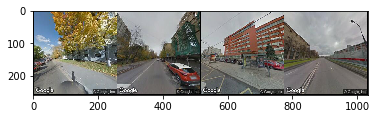

In [209]:
#print(dir(transforms))
composed = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
train_set = MyImageFolder('./LittlePlaNet/data/cities/', transform=composed)
img, label = train_set[119]
len(img)
grd = torchvision.utils.make_grid(img)
grd = np.transpose(grd, [1, 2, 0])
plt.imshow(grd)
# print(label)

# Но зачем все это ?

# Ответ - для DataLoader'а

In [8]:
def imshowTensor(img):
    npimg = np.squeeze(img.numpy().astype('uint8'))
    plt.imshow(npimg, cmap='gray')

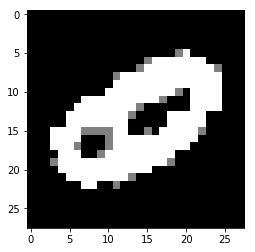

In [11]:
#print(dir(transforms))
#transforms.RandomCrop(10, padding=4),
composed = transforms.Compose([
                transforms.Grayscale(1),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
train_set = ImageFolder('./mnist/training/', transform=composed)
imshowTensor(train_set[5][0])
#dataloader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True, num_workers=2)

In [ ]:
batchsize = 1000
lr = 0.01
momentum = 0.9
epoches = 10
log_interval = 10
#transforms.Grayscale(1),
composed = transforms.Compose([
                transforms.Grayscale(1),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
composed_test = transforms.Compose([
                transforms.Grayscale(1),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

train_set = ImageFolder('./mnist/training/', transform=composed)
test_set = ImageFolder('./mnist/testing/', transform=composed_test)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchsize, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

def train(epoch, losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        losses.append(loss.data[0])
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

NameError: name 'lr' is not defined

In [17]:
losses = [] 
for epoch in range(1, epoches + 1):
    train(epoch, losses)
    test()
plt.plot(losses)

NameError: name 'epoches' is not defined

# О ДЗ

1) Опираемся для сборки модели на статью авторов ResNet https://arxiv.org/pdf/1512.03385.pdf - секция 4.2. CIFAR-10 and Analysis

2) Там описаны базовая топология ResNet для CIFAR-10. Отличия модели нужной для ДЗ от описанной - на выходе Dense-слой со 100 нейронами(100 классов). Во всем остальном собираем модель, описанную автором.

3) Не обязательно строго следовать рекоммендациям авторов относительно аугментаци и алгоритма обучения, а так же гиперпараметов(используйте что хотите, но я советую присмотреться к SGD с nesterov = True)

4) В файле Homework_4_Clear.ipynb найдете скелет для сборки ResNet-ов разных размеров. Надо правильно адаптировать Basic/Bottleneck блоки из лекции + дописать части, касающиеся downsampling'а. Далее обучить модель, выбить score > Baseline.